In [1]:
# Till Wagner's python version:
#
# Reference: "How Model Complexity Influences Sea Ice Stability",
# T.J.W. Wagner & I. Eisenman, J Clim (2015)
#
# WE15_EBM_simple.m:
# This code describes the EBM as discussed in Sec. 2b of the article above,
# hereafter WE15. Here we use central difference spatial integration and
# time stepping with MATLAB's ode45.
#
# The code WE15_EBM_fast.m, on the other hand, uses a faster, but more
# complicated formulation of the diffusion operator and Implicit Euler time
# stepping.
#
# Parameters are as described in WE15, table 1. Note that we do not include
# ocean heat flux convergence or a seasonal cylce in the forcing
# (equivalent to S_1 = F_b = 0 in WE15). This code uses an ice albedo when
# T<0 (WE15 instead uses the condition E<0, which is appropriate for the
# inclusion of a seasonal cycle in ice thickness). In this code, we define
# T = Ts - Tm, where Ts is the surface temperature and Tm the melting point
# (WE15, by contrast, defines T = Ts).
#
# Till Wagner & Ian Eisenman, Mar 15
# tjwagner@ucsd.edu or eisenman@ucsd.edu
##-------------------------------------------------------------------------

## Import the required modules
import numpy as np
import matplotlib.colors as mcolors
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [193]:
## Model parameters (WE15, Table 1 and Section 2d) ------------------------
D = 0.6 # diffusivity for heat transport (W m^-2 K^-1)
A = 193 # OLR when T = 0 (W m^-2)
B = 2.1 # OLR temperature dependence (W m^-2 K^-1)
cw = 9.8 # ocean mixed layer heat capacity (W yr m^-2 K^-1)
S0 = 420 # insolation at equator (W m^-2)
S2 = 240 # insolation spatial dependence (W m^-2)
## co-albedo: 1 - albedo
a0 = 0.7 # ice-free co-albedo at equator
a2 = 0.1 # ice=free co-albedo spatial dependence
ai = 0.4 # co-albedo where there is sea ice
F = 0.0 # radiative forcing (W m^-2)
# -------------------------------------------------------------------------
n = 50 # grid resolution (number of points between equator and pole)
x = np.linspace(0,1,n)
dx = 1.0/(n-1)
S = S0-S2*x**2 # insolation [WE15 eq. (3) with S_1 = 0]
aw = a0-a2*x**2 # open water albedo
# ODE with spatial finite differencing-------------------------------------

## Define the function that evaluates the temperature at the next timestep
def odefunc(T,t):
    alpha = aw*(T>0)+ai*(T<0)
    C = alpha*S-A+F
    Tdot = np.zeros(x.shape)
    # solve c_wdT/dt = D(1-x^2)d^
    for i in range(1,n-1):
        # solve c_w dT/dt = D (1-x^2) d^2 T/dx^2 - 2 x D dT/dx + C - B T [cf. WE15 eq. (2)]
        Tdot[i]=(D/dx**2)*(1-x[i]**2)*(T[i+1]-2*T[i]+T[i-1])-(D*x[i]/dx)*(T[i+1]-T[i-1])
        # use central difference
        Tdot[0] = D*2*(T[1]-T[0])/dx**2
        Tdot[-1] = -D*2*x[-1]*(T[-1]-T[-2])/dx
    f = (Tdot+C-B*T)/cw
    return f

In [194]:
### Problem 1: Temperature distribution after 30 years without anthropogenic forcing
## Perform the run without anthropogenic forcing (i.e., F=0)
F = 0.0
T0 = 10*np.ones(x.shape)            # initial condition (constant temp. 10C everywhere)
time = np.linspace(0.0,30.,1000)    # time span in years (30.0) with 1000 timesteps
T = odeint(odefunc,T0,time)         # solve

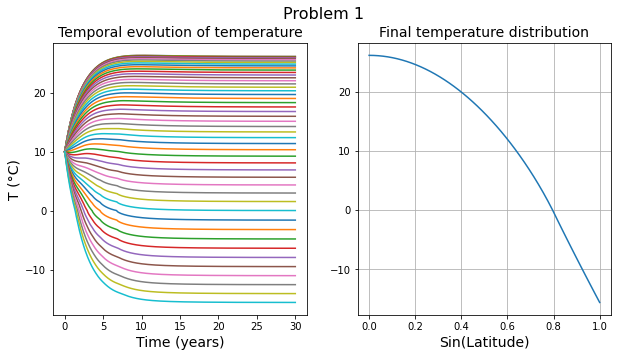

In [195]:
## Plotting
fs = 14

fig,ax = plt.subplots(1,2,figsize=(10,5),squeeze=True)
ax[0].plot(time,T)
ax[0].set_xlabel('Time (years)',fontsize=fs)
ax[0].set_ylabel('T (°C)',fontsize=fs)
ax[0].set_title('Temporal evolution of temperature',fontsize=14)

ax[1].plot(x,T[-1,:])
ax[1].set_xlabel('Sin(Latitude)',fontsize=fs)
ax[1].set_title('Final temperature distribution',fontsize=fs)
ax[1].grid()

fig.suptitle('Problem 1', fontsize=fs+2)
plt.savefig('problem/ex1_sol.png',dpi=300)